# Worksheet 04: Binary or Discrete Counts Responses

## Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. Describe the logistic regression estimation procedure (binary response variable) and Poisson regression estimation procedure (discrete counts as the response variable).
2. Discuss the relationship between linear regression and logistic and Poisson regression. Discuss the consequences of modelling data more suitable for logistic and Poisson regression models as a linear regression model.
3. Interpret the coefficients and $p$-values in the logistic and Poisson regression settings.
4. Write a computer script to perform logistic and Poisson regression and perform model diagnostics. Interpret and communicate the results from that computer script.

In [1]:
# Run this cell before continuing.
library(MASS)
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(mlbench)
library(AER)
library(ISLR)
library(broom)
library(qqplotr)
library(performance)
library(see)
library(glmbb)
library(cowplot)
source("tests_worksheet_04.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following ob

## 0. Intro

So far, you have explored the Multiple Linear Regression (MLR) as a way to model the mean of a numeric response variable, $Y$, given a set of covariate $\mathbf{X}$:

$$
E\left[Y\left|\mathbf{X}=\left(X_1,...,X_p\right)\right.\right] = \beta_0 + \beta_1X_1 + \ldots + \beta_pX_p
$$

However, in some situations, the MLR is not suitable. This week, we are going to study two of those situations that commonly arise in practice:

- **in this worksheet**: the case of dichotomous response variables (e.g., yes/no, success/failure, win/lose, sick/not sick)  

- **in the tutorial**: the case of response variables representing counts (e.g., number of cases of a rare disease in Vancouver in one year; the number of accidents on the Canada Highway in one month).

## 1. Logistic Regression

Logistic Regressions are commonly used to model the probability of an event based on a set of observed covariates. As with Linear Regression, Logistic Regression can also be used to:

- estimate and test the true relation between different types of variables and a <u>*binary response*</u>.


- predict the probability of a <u>*binary response*</u> (aka, classifier)

<br>

For example, we can use a logistic regression to

1. compare the presence of bacteria between groups taking a new drug and a placebo, respectively.
    - Response: *present* or *not present*

<br>

2. predict whether or not a customer will default on a loan given their income and demographic variables.
    - Response: *default* or *not default*

<br>

3. know how GPA, ACT score, and number of AP classes taken are associated with the probability of getting accepted into a particular university.
    - Response: *accepted* or *not accepted*
    

<br>


### The response variable:

The function in R to fit a logistic regression requires either a numerical response (0 and 1) or a `factor`, with two levels (note that R stores factors as integers). 

Mathematically, we have to construct a binary response $Y_i$ that flags the successes (S) for a given event of interest: 

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is S},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

In the examples above, we would set:

1. $Y_i = 1$ if the bacteria is present in the blood sample of the $i$th patient 


2. $Y_i = 1$ if the $i$th customer defaulted on their loan


3. $Y_i = 1$ if the $i$th student was accepted to a particular university


In statistics, we refer to each $Y_i$ as a Bernoulli trial with a $p_i$ probability of success, i.e., 

$$Y_i \sim \text{Bernoulli}(p_i)$$

where 

$$
E(Y_i) = p_i
$$

This worksheet will focus on the dataset `Default` from [*An Introduction to Statistical Learning*](https://www.statlearning.com/) (James et al., 2013). This is a dataset of $n = 10,000$ observations with the following variables:

- `default`: a binary response indicating whether the customer defaulted on their debt (`Yes` or `No`).
- `student`: a binary input variable indicating whether the customer is a student (`Yes` or `No`).
- `balance`: a continuous input variable indicating the remaining average balance of the customer's credit card (after the monthly payment).
- `income`: a continuous input variable indicating the customer's income.

In [2]:
head(Default)

default student balance   income   
1 No      No       729.5265 44361.625
2 No      Yes      817.1804 12106.135
3 No      No      1073.5492 31767.139
4 No      No       529.2506 35704.494
5 No      No       785.6559 38463.496
6 No      Yes      919.5885  7491.559

### Simple Linear Regression for Binary Data

In this first exercise, we use a simple linear regression (SLR) to estimate the relation between `balance` and the response `default`.

A SLR will model: 

$$
E\left[\ \texttt{default}_i\ |\ \texttt{balance}_i\ \right] = \beta_0 + \beta_1\times \texttt{balance}_i
$$

However, since `default` is a binary variable, we also know that: 

$$
E\left[\ \texttt{default}_i\ |\ \texttt{balance}_i\ \right] = p_{\texttt{default} | \texttt{balance}_i}
$$

this means that the conditional expectation $E\left[\ \texttt{default}_i\ |\ \texttt{balance}_i\ \right]$ is  equal to the **probability** that a customer with $\texttt{balance}_i$ will default (denoted above as $p_{\texttt{default} | \texttt{balance}_i}$).

Let's examine if there is a problem using a linear regression to model this conditional expectation. 

**Question 1.1**
<br>{points: 1}

Create a plot of the data (using `geom_point()`) along with the estimated regression line (using `geom_smooth()` with `method = "lm"`). Include proper axis labels. The `ggplot()` object's name will be `default_SLR_plot`.

The first clue that fitting a simple linear regression (SLR) to this data may be problematic is that R will complain about fitting an SLR with a categorical variable. Therefore, we need to convert the 'default' variable to numeric in order to fit the SLR.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

`geom_smooth()` using formula = 'y ~ x'


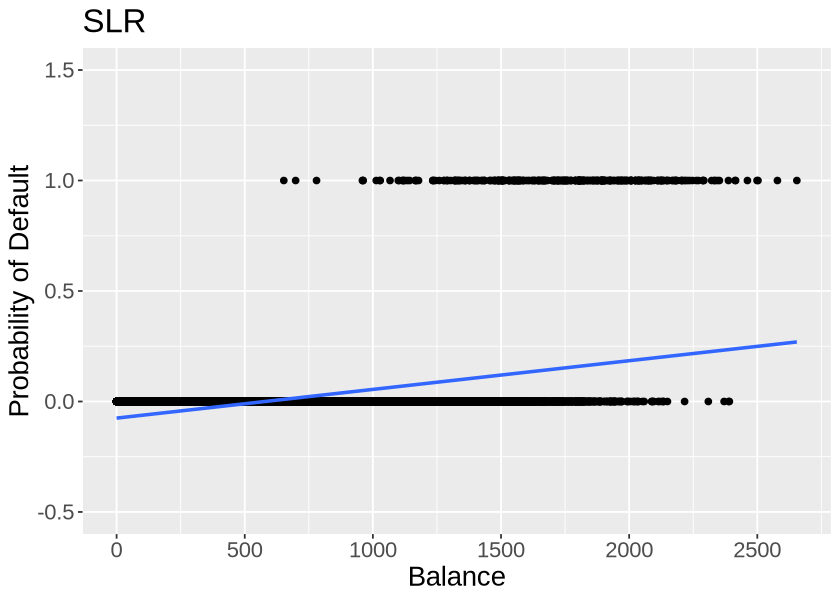

In [4]:
# Adjust these numbers so the plot looks good in your desktop.
options(repr.plot.width = 7, repr.plot.height = 5) 

# default_SLR_plot <- 
#     Default %>%
#     mutate(default = if_else(default == "Yes", ..., ...)) %>%
#     ...
#   ...(aes(..., ...)) +
#   ...(aes(..., ...), method = ..., se = FALSE) +
#   labs(y = ..., x = ...) +
#   ggtitle(...) +
#   ylim(-0.5, 1.5) +
#   theme(text = element_text(size = 16.5)) +
#   scale_x_continuous(breaks = seq(0, 2500, 500))


# your code here
#fail() # No Answer - remove if you provide an answer
 default_SLR_plot <- 
     Default %>%
     mutate(default = if_else(default == "Yes", 1, 0)) %>%
     ggplot()+
   geom_point(aes(balance, default)) +
   geom_smooth(aes(balance, default), method = "lm", se = FALSE) +
   labs(y = "Probability of Default", x = "Balance") +
   ggtitle("SLR") +
   ylim(-0.5, 1.5) +
   theme(text = element_text(size = 16.5)) +
   scale_x_continuous(breaks = seq(0, 2500, 500))
default_SLR_plot

In [5]:
test_1.1()

Test passed 🥇
Test passed 🎉
Test passed 🥇
Test passed 🌈
Test passed 🥳
Test passed 🎉
Test passed 😸
[1] "Success!"


#### Discussion

Do you see any problems with our model? Discuss it with a colleague.

### Logistic Regression: an alternative to LR

The problem stems from using the *linear* model to estimate a probability. 

Mathematically, the linear component $\beta_0 + \beta_1X_{i1} + ... +\beta_pX_{ip}$ can take any value, while probabilities is **always** between 0 and 1.

A natural way to solve this problem is to use a curve, instead of a line, with a range between $[0,1]$. One such curve is the logistic curve:

$$E(Y_i|X_i) = p_i = \frac{e^{\beta_0 + \beta_1X_i}}{1+e^{\beta_0 + \beta_1X_i}}$$ 

Note that <font style='color:darkred'>we are still using a linear component but not to model the conditional expectation directly</font>. 

With some algebra, we can show that:

\begin{equation*}
\log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1 X_i
\end{equation*}

**Definition**: $p_i$ to $1 - p_i$ are also known as the **odds** and can be estimated by *number of sucesses* to *number of failures*

For example, among 7056 non-student customers, 206 defaulted on their debt. Thus, the odds that non-student customers default is 206 to 6850. 

The function $\log\left(\frac{p_i}{1 - p_i}\right)$ is called **logit**, and it is *logarithm of the odds*. 

Let's explore this new function a bit.

**Question 1.2**
<br>{points: 1}

Let's see what the logistic curve looks like. In this exercise, you will plot the logistic curve to see how it behaves.

_Save the plot in an object named `logistic_curve`._

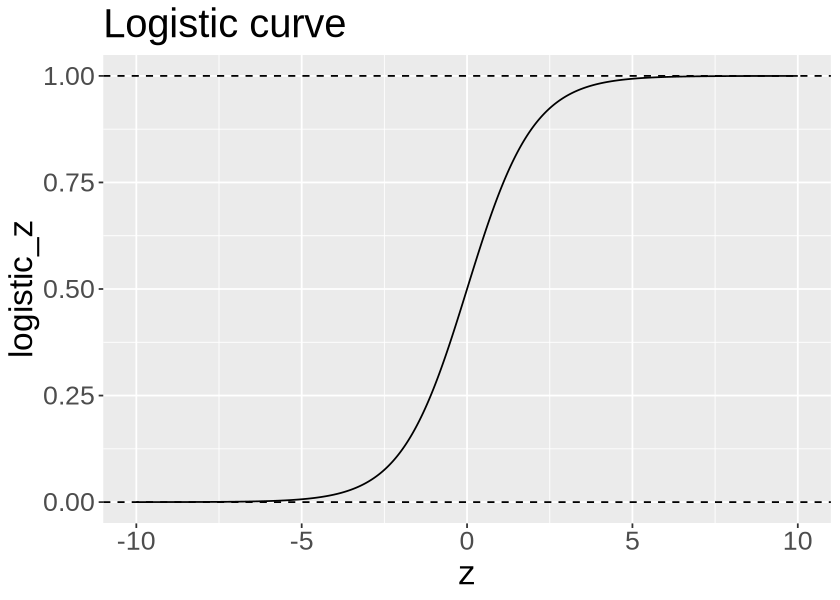

In [8]:
# logistic_curve <-
#     tibble(z = seq(-10,10,0.01),
#            logistic_z = ... %>% 
#     ggplot(aes(z, ...)) + 
#     geom_line() +
#     geom_hline(yintercept = 1, lty=2) + 
#     geom_hline(yintercept = 0, lty=2) +
#     theme(text = element_text(size = 20)) + 
#     ggtitle("Logistic curve")

# your code here
#fail() # No Answer - remove if you provide an answer
 logistic_curve <-
     tibble(z = seq(-10,10,0.01),
            logistic_z = exp(z)/(1+exp(z))) %>% 
     ggplot(aes(z, logistic_z)) + 
     geom_line() +
     geom_hline(yintercept = 1, lty=2) + 
     geom_hline(yintercept = 0, lty=2) +
     theme(text = element_text(size = 20)) + 
     ggtitle("Logistic curve")
logistic_curve

In [9]:
test_1.2()

Test passed 🌈
Test passed 🎊
Test passed 🎉
Test passed 🎊
Test passed 😸
Test passed 🎊
[1] "Success!"


**Question 1.3: Understanding the odds**
<br>{points: 1}

Vancouver Canucks is playing against Calgary Flames in the Final of the NHL. The match will be at Rogers' arena, Canucks home. It is expected that out of 18,910 seats in the arena, 13,700 seats will be occupied by Canucks fans. During the match, prizes are randomly distributed among the seats. What are the odds that a Canucks fan wins a given prize? 

Assign your answer to an object named `answer1.3`.

In [12]:
#answer1.3 <- ...

# your code here
#fail() # No Answer - remove if you provide an answer

answer1.3<-13700/(18910-13700)
answer1.3

[1] 2.629559

In [11]:
test_1.3()

Test passed 🥇
Test passed 🥇
Test passed 😸
[1] "Success!"


**Question 1.4:**
<br>{points: 1}

Let us plot the predictions of the binary logistic regression model on top of `default_SLR_plot`. Use `geom_smooth()` with `method = "glm"` and `method.args = c(family = binomial)`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


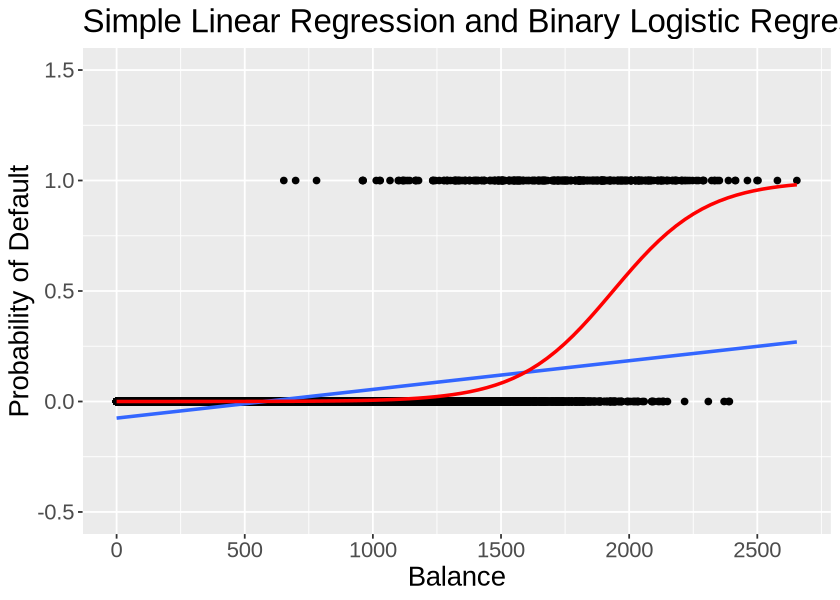

In [13]:
# default_SLR_plot <- 
#     default_SLR_plot +
#     ...(aes(..., ...),
#         method = ...,
#         method.args = ..., 
#         se = FALSE, color = "red") +
#     ggtitle("Simple Linear Regression and Binary Logistic Regression")

# your code here
#fail() # No Answer - remove if you provide an answer
 default_SLR_plot <- 
     default_SLR_plot +
     geom_smooth(aes(balance, default),
         method = "glm",
         method.args = c(family = binomial), 
         se = FALSE, color = "red") +
     ggtitle("Simple Linear Regression and Binary Logistic Regression")
default_SLR_plot

In [14]:
test_1.4()

Test passed 🌈
Test passed 🌈
Test passed 😸
Test passed 🥳
Test passed 🌈
Test passed 😀
Test passed 🎉
[1] "Success!"


Much better, isn't it? 

#### The model

Let's review our model!

The response: 

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is a success},\\
0 \; \; \; \; 	\mbox{otherwise}
\end{cases}
$$

can only take the values $0$ or $1$. 

The conditional expected value of this variable is the probability that $Y_i$ takes on the value of $1$ (or probability of success), given the values of $X_i$, denoted as $p_i$. Hence:

$$\left.Y_i\right|\mathbf{X}_{i} \sim \text{Bernoulli}(p_i).$$

The **logistic regression** models the conditional probability $p_i$ given the information of a set of covariates but *not* directly as a linear function of them. Instead, it re-expresses $p_i$ on an unrestricted scale, called the log-odds:

$$
\mbox{logit}(p_i) = \log \bigg( \frac{p_i}{1 - p_i}\bigg) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \ldots + \beta_{q} X_{iq},
$$

Again, the logarithm of the odds is the logarithm of the ratio of the probability of a sucess to the probability of a failure of an event

Or equivalently

$$
p_i = \frac{\exp\big[\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \ldots + \beta_{q} X_{iq}\big]}{1 + \exp\big[\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \ldots + \beta_{q} X_{iq}\big]}.
$$

In our example,

$$
\mbox{logit}(p_{i,\texttt{default}}) = \log \bigg( \frac{p_{i,\texttt{default}}}{1 - p_{i,\texttt{default}}}\bigg) = \beta_0 + \beta_1\texttt{balance}_i
$$

or equivalently

$$
p_{i,\texttt{default}} = \frac{e^{\beta_0 + \beta_1 \texttt{balance}_i}}{1 + e^{\beta_0 + \beta_1  \texttt{balance}_i}}.
$$

In this example, the *odds* are interpreted as how likely the $i$th customer is to be in default compared to how unlikely it is at a fixed value of their balance. 

### 1.1 Estimation

The question now is, how do we estimate the coefficients $\beta_j$'s? 

So far, in the case of linear regression, we have been using the Least Square Estimators. However, due to the type of response of the logistic model, this objective function is no longer appropriate.

A common method for estimating a logistic regression (and many other models) is *Maximum Likelihood Estimation (MLE)*. Details of MLE are outside the scope of this course, but we will still implement it using R! 


#### Interpretation

As before, the interpretation of the coefficients will depend on the type of input variable. 

Let's start by looking at a model with only 1 categorical covariate, such as being or not being a student. We know that `R` will create a dummy variable $X$ to include in the model in this case. But how do we interpret its coefficient?

Let's refresh our memory for **Linear Regression**:

- *Intercept:* was the mean of the response of the reference group (and the *estimate* was the *sample* mean)

- *Slope:* was the *difference* between the mean of the response of the treatment group vs that of the reference group (and the *estimate* was the difference of *sample* means)

However, for LR, we modelled the expected value of the response directly. We now need to adjust the interpretations to changes in log-odds.

- Intercept: $\hat{\beta}_0$ represents the log odds of the reference group (e.g., non-students)

- Slope: $\hat{\beta}_1$ represents the difference in log odds between the treatment and the reference group (e.g., students vs. non-students)

Since log-odds are difficult to interpret, it is common to also interpret the exponentiated version of the coefficients:

- Intercept: $e^{\hat{\beta}_0}$ represents the odds of the reference group, i.e., the proportion of success relative to the proportion of failures in the sample 

- Slope: $e^{\hat{\beta}_1}$ represents the *odds ratio*, i.e., the ratio between the odds of the treatment vs the odds of the reference group

*Run the cell below to compute these quantities. Read and follow calculations*

In [15]:
Default %>% 
    select(default, student) %>% 
    group_by(default, student) %>%
    summarise(n=n(), .groups = 'drop')

default student n   
1 No      No      6850
2 No      Yes     2817
3 Yes     No       206
4 Yes     Yes      127

In [16]:
# b0 = \hat{beta}_0

tot_studentNo <- 6850 + 206

# probability of default if non-student
# note that the same is true for #default1_studentNo/#default0_studentNo
p_studentNo <- 206/tot_studentNo

b0 <- log(p_studentNo/(1-p_studentNo))

# b1 = \hat{beta}_1
tot_studentYes <- 2817 + 127

# probability of default if student
p_studentYes <- 127/tot_studentYes

# log odds of students vs. log odds of non-students
b1 <- log(p_studentYes/(1-p_studentYes)) - b0

print("log-odds for non-students (b0) and for students")
c(b0, log(p_studentYes/(1-p_studentYes))) %>%
    round(3)

print("odds for non-students (exp(b0)) and for students")
c(exp(b0), (p_studentYes/(1-p_studentYes))) %>%
    round(3)

print("odds ratio (exp(b1))")
c(exp(b1), (p_studentYes/(1-p_studentYes))/(p_studentNo/(1-p_studentNo))) %>% 
  round(3)

[1] "log-odds for non-students (b0) and for students"


[1] -3.504 -3.099

[1] "odds for non-students (exp(b0)) and for students"


[1] 0.030 0.045

[1] "odds ratio (exp(b1))"


[1] 1.499 1.499

**Question 1.5:**
<br>{points: 1}

To fit the model, we can use the function `glm()` and its argument `family = binomial` (required to specify the binary nature of the response). 

Now, let's put this into practice. We'll estimate a binary logistic regression utilizing the function `glm()` with `default` as the response and `student` as the input variable. The dataset is `Default`.
    
Store the model in an object named `default_binary_log_student`. The `glm()` parameters are analogous to `lm()` (`formula` and `data`) with the addition of `family = binomial` for this specific model. 

In [17]:
# default_binary_log_student <- 
#   ...(formula = ...,
#       data = ...,
#       family = ...)


# your code here
fail() # No Answer - remove if you provide an answer

summary(default_binary_log_student)

ERROR: Error: Failure has been forced


In [ ]:
test_1.5()

Note that you can also use the function `tidy()` to obtain a summary table of results.

In [ ]:
#Run this cell to get a tidy summary table

default_binary_log_student_results  <-
    default_binary_log_student %>%
    tidy() %>% 
    mutate(exp.estimate = exp(estimate)) 

default_binary_log_student_results 

You can also get the exponentiated coefficients with the argument `exponentiate = TRUE` in `tidy()`.

In [ ]:
default_binary_log_student %>% 
    tidy(exponentiate = TRUE) 

**Note**:  that the `std.error` column still refers to the non-exponentiated estimators, e.g., it refers to $\hat{\beta}_0$ not $e^{\hat{\beta}_0}$

**Question 1.6**
<br>{points: 1}

Considering the `default_binary_log_student_results` tibble, what is the correct interpretation of the  $\hat{\beta}_\textit{student}$?

**A.** The odds of default are $49.9\%$ higher for non-student customers than student customers.

**B.** The odds of default are $49.9\%$ higher for student customers than non-student customers.

**C.** The odds of default are $40.5\%$ higher for non-student customers than student customers.

**D.** The odds of default are $40.5\%$ higher for student customers than non-student customers.

*Assign your answer to the object `answer1.6` (character type surrounded by quotes).*

In [ ]:
# answer1.6 <- ...

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_1.6()

#### Multiple covariates

The interpretation extends to the case of more covariates of different types.

- $\hat{\beta}_1$ gives the changes in log odds per one-unit increase in X, 
    - or equivalently it multiplies the odds by $e^{\hat{\beta}_1}$
    
Because the relationship between $p_i$ and $X_i$ is not a straight line, $\hat{\beta}_1$ does not correspond to the change in $p_i$ associated with a one-unit change in $X_i$. But regardless,
if $\hat{\beta}_1$ is positive then increasing $X_i$ will be associated with increasing $p_i$ and visceversa.

> Note that when the odds decrease, i.e., negative change in log-odds, it is easier to interpret $1/e^{\hat{\beta}_1}$.
>
> That is, to redefine
 $\text{odds} = \frac{\text{failures}}{\text{successes}}$

**Question 1.7:**
<br>{points: 1}

In order to fit the model, we can use the function `glm()` and its argument `family = binomial` (required to specify the binary nature of the response). 

Let us use the function `glm()` to estimate a binary logistic regression. Using the `Default` dataset, we will fit a binary logistic model with `default` as the response and `student`, `balance`, and `income` as input variables.
    
Store the model in an object named `default_binary_log_model`. The `glm()` parameters are analogous to `lm()` (`formula` and `data`) with the addition of `family = binomial` for this specific model. 

In [ ]:
# default_binary_log_model <- 
#   ...(...,
#       ...,
#       ...)

# your code here
fail() # No Answer - remove if you provide an answer

default_binary_log_model %>%
    tidy() %>% 
    mutate_if(is.numeric, round, 3)

default_binary_log_model %>%
    tidy(exponentiate = TRUE) %>% 
    mutate_if(is.numeric, round, 3)

In [ ]:
test_1.7()

**Question 1.8**
<br>{points: 1}

Considering the `default_binary_log_model_results` tibble, what is the correct interpretation of the  $\hat{\beta}_\textit{student}$?

**A.** Since $1 / 0.524 = 1.908$, we estimate that the odds of non-default are $90.8\%$ higher for non-student customers than student customers while keeping the rest of the input variables constant.

**B.** Since $1 / 0.524 = 1.908$, we estimate that the odds of default are $90.8\%$ higher for non-student customers than student customers while keeping the rest of the input variables constant.

**C.** Since $1 / 0.524 = 1.908$, we estimate that the odds of non-default are $90.8\%$ higher for student customers than non-student customers while keeping the rest of the input variables constant.

**D.** Since $1 / 0.524 = 1.908$, we estimate that the odds of default are $90.8\%$ higher for student custormers than non-student customers, while keeping the rest of the input variables constant.

*Assign your answer to the object `answer1.8` (character type surrounded by quotes).*

In [ ]:
# answer1.8 <- ...

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_1.8()

**Question 1.9**
<br>{points: 1}

What is the correct interpretation of the regression equation's estimated slope for `balance`?

**A.** A $\$1$ increase in `balance` is associated with a $0.6\%$ increase in the odds of a customer defaulting while keeping the rest of the input variables constant. 

**B.** A $\$1$ increase in `balance` is associated with a $0.6\%$ increase in the odds of a customer not being in default while keeping the rest of the input variables constant.  

**C.** A $\$1$ increase in `balance` is associated with a $0.6\%$ increase in the odds of a student customer defaulting while keeping the rest of the input variables constant.  

**D.** A $\$1$ increase in `balance` is associated with a $0.6\%$ increase in the odds of a non-student customer defaulting while keeping the rest of the input variables constant.

*Assign your answer to the object `answer1.9` (character type surrounded by quotes).*

In [ ]:
# answer1.9 <- ...

# your code here
fail() # No Answer - remove if you provide an answer


In [ ]:
test_1.9()

### 1.2 Inference

We can use this estimated model to make inferences about the population parameters, i.e., we can determine whether an input variable is statistically associated with the logarithm of the odds through hypothesis testing for the parameters $\beta_j$. 

To do that, we need additional information about the estimators of the regression coefficients, $\hat{\beta}_j$. In particular, we need their sampling distribution and corresponding standard errors, $\mbox{SE}\left(\hat{\beta}_j\right)$. 

**Theoretical test**:

To test the hypotheses
\begin{gather*}
H_0: \beta_j = 0\\
H_a: \beta_j \neq 0.
\end{gather*}

You can use the Wald statistic $z_j$

$$z_j = \frac{\hat{\beta}_j}{\mbox{SE}\left(\hat{\beta}_j\right)}$$

which under $H_0$ has an approximately standard normal distribution provided the sample size $n$ is large enough. This statistic is analogous to the $t$-value used in LR. 

Furthermore, given a specified level of confidence, we can construct approximate $(1 - \alpha) \times 100\%$ confidence intervals for the corresponding true value of $\beta_j$:

$$\hat{\beta}_j \pm z_{\alpha/2}\mbox{SE}\left(\hat{\beta}_j\right),$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the standard normal distribution.

**Question 1.10: Inference**
<br>{points: 1}

Report the estimated coefficients, their standard errors, and corresponding $p$-values by calling `tidy()` on `Default_binary_log_model`. Include the corresponding asymptotic 95% confidence intervals. 

_Store the results in the variable `Default_binary_log_model_results`._

In [ ]:
# default_binary_log_model_results <- 
#    ... %>%
#    ...(conf.int = TRUE) 

# your code here
fail() # No Answer - remove if you provide an answer

default_binary_log_model_results

In [ ]:
test_1.10()

**Question 1.11: Inference**
<br>{points: 1}

Use `tidy()` to  the estimated effect each of the variables has on the *odds* to the `default_binary_log_model_results` tibble. Make sure to also include the confidence interval for these effects.

In [ ]:
# default_binary_odds_model_results <- 
#    default_binary_log_model %>%
#    ... %>%
#    mutate_if(is.numeric, round, 6)

# your code here
fail() # No Answer - remove if you provide an answer

default_binary_odds_model_results

In [ ]:
test_1.11()

**Question 1.12**
<br>{points: 1}

Using a **significance level $\alpha = 0.05$**, which inputs are statistically associated to the probability of default in `Default_binary_log_model_results`?

**A.** The categorical input `student`.

**B.** The continuous input `balance`.

**C.** The continuous input `income`.

*Assign your answers to the object `answer1.12`. Your answers must be included in a single string indicating the correct options in alphabetical order and surrounded by quotes (e.g., `"ABC"` indicates you are selecting the three options).*

In [ ]:
# answer1.12 <- 

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_1.12()

### 1.3 Prediction

Besides inference, we can use an estimated logistic regression model to predict the probability of success. 

\begin{gather*} 
\log \bigg( \frac{\hat{p}_i}{1 - \hat{p}_i}\bigg) = \hat{\beta}_0 +\hat{\beta}_1 x_{i1} + \ldots + \hat{\beta}_p x_{iq} \\
\end{gather*}

where lower letters $x$ denote a particular observed value for the $i$th experimental unit.

For example, suppose we want to predict the odds of a student who has a credit card balance of \\$2200 and an income of \\$35000 to be in default relative to not being in default.

Mathematically, our predicted log odds will be 

\begin{gather*} 
\log \bigg( \frac{\hat{p}_\texttt{default}}{1 - \hat{p}_\texttt{default}}\bigg) = \underbrace{-10.869045}_{\hat{\beta}_0} - \underbrace{0.646776}_{\hat{\beta}_1} \times 1 + \underbrace{0.005737}_{\hat{\beta}_2} \times 2200 + \underbrace{0.000003}_{\hat{\beta}_2} \times 35000= 1.21 \\
\end{gather*}

Next, by taking the exponential on both sides of the equation, we obtain our predicted *odds*: 

$$
\frac{\hat{p}_\texttt{default}}{1 - \hat{p}_\texttt{default}} = e^{1.21} = 3.36.
$$

Finally, solving the above for $\hat{p}_\texttt{default}$, we obtain our predicted probability of default

$$
\hat{p}_\texttt{default} = 3.36/4.36 = 0.7706
$$

**Question 1.13**
<br>{points: 1}

Using `predict` and `default_binary_log_model`, obtain the odds prediction above.

*Hint: Check the argument `type` when coding this prediction.*

*Assign your answer to the object `answer1.13`. Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# answer1.13 <- 
#     ...(...,
#         tibble(student = ..., balance = ..., income = ...),
#         type = ...) %>%
#     ... # how did you obtain the predicted odds above? 

# your code here
fail() # No Answer - remove if you provide an answer

answer1.13

In [ ]:
test_1.13()

**Question 1.14**
<br>{points: 1}

We can also predict probabilities for classification purposes, i.e., whether the customer will default. Using the function `predict()` with the object `default_binary_log_model`, obtain the estimated probability that a given customer will default. This customer is a `student` who has a credit card `balance `2200` and income of `35000`.


*Hint: Check the argument `type` when coding this prediction.*

*Assign your answer to the object `answer1.14`. Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# answer1.14 <- 
#     ...(...,
#         tibble(...),
#         type = ...)

# your code here
fail() # No Answer - remove if you provide an answer

answer1.14

In [ ]:
test_1.14()

**Overdispersion**

The variance of a binary response variable is a function of the mean: $p(1-p)$. This means that the estimate of the mean also provides an estimate of the variance of the response. 

Since the logistic regression is built assuming that the response is *Bernoulli*, the estimated $\hat{p}$ conditions the estimated variance of the response to be $\hat{p}(1-\hat{p})$.  

Unfortunately, in real applications, even in situations where the model seems to be estimating the mean well, the data's variability is not quite compatible with the model's assumed variance. <font style='color: darkred'>This misspecification in the variance affects the SE of the coefficients, not their estimates.</font>

A way around this problem is to estimate a dispersion parameter, usually called $\phi$, to correct the standard error of our estimators. An easy implementation is to change the `family` argument to a `quasibinomial`. Let's see an example.  

In [ ]:
summary(glm(
    formula = default ~ student + balance + income,
    data = Default,
    family = quasibinomial))

Note that the estimates haven't changed, but the SE was adjusted to account for some overdispersion in the data.

### 1.4 Conclusions

- The (conditional) expectation of a binary response is the probability of success.

- A LR can not be used to model the conditional expectation of a binary response since its range extends beyond the interval $[0,1]$

- Instead, one can model a function of the conditional probability. A common choice in logistic regression is to use the *logit* function (logarithm of odds)

- The interpretation of the coefficients depends on the type of variables and the form of the model:

The raw coefficients are interpreted as:

- log odds of a reference group
- difference of log odds of a treatment vs a control group
- changes in log odds per unit change in the input
    
The exponentiated coefficients are interpreted as:
- odds of a reference group
- odds ratio of a treatment vs a control group
- multiplicative changes in odds per unit change in the input
    
- The estimated logistic model can be used to make inference using the Wald's test

- The estimated logistic model can be used to make predictions
    - the probability of success
    - the odds of success relative to failure